# Классификация текстов

В этой лабораторной работе вам предстоит сравнить между собой различные алгоритмы классификации текстов на одной и той же коллекции текстов. Коллекция текстов состоит из 11000 новостных статей, принадлежащих 5 возможным классам: культура, общество, политика, экономика, спорт. 

Коллекция текстов заранее разбита на обучающее и тестовое множества, в обучающем – 2000 текстов, в тестовом – 200. 

Ваша задача – сравнить между собой несколько алгоритмов классификации и выбрать лучший из них по аккуратности и F1-мере. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(1228)
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
%matplotlib inline

Тексты заранее предобработаны и сохранены в .pkl-файлы. Выберите один из вариатов предобработки:
* articles.pkl – все слова в нижнем регистре
* articles_no_SW.pkl – все слова в нижнем регистре, тексты очищены от стоп-слов (по списку из NLTK)
* articles_lemmatized.pkl – все слова в нижнем регистре, все слова лемматизированы (mystem3)
* articles_lemmatized_no_SW.pkl – все слова в нижнем регистре, все слова лемматизированы (mystem3), тексты очищены от стоп-слов (по списку из NLTK)

In [4]:
data = pd.read_csv("../data/articles_lemmatized_noSW.csv")

Разбиение на тестовое и обучающее множество

In [3]:
data = data[data.topic.isin(("Культура", "Общество", "Политика", "Экономика", "Спорт"))] 
corpus_sample_train = pd.DataFrame(columns=data.columns)
corpus_sample_test = pd.DataFrame(columns=data.columns)

for topic in data.topic.unique():
    corpus_sample = data[data.topic==topic].sample(2200)
    corpus_sample_train = corpus_sample_train.append(corpus_sample.iloc[:2000, :])
    corpus_sample_test = corpus_sample_test.append(corpus_sample.iloc[2000:, :])

In [5]:
len(corpus_sample_train)

10000

## Традиционные алгоритмы классификации
Возможные варианты алгоритмов классификации (можно использовать и другие):
* Наивный Байесовский классификатор (MultinomialNB, http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
* Машины опорных векторов (SGDClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
* Случайные леса (RandomForestClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* Метод максимальной энтропии http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD


Будем классифицировать тексты как "мешки слов". Это значит, что каждое слово или каждая н-грамма задает свою координату в векторном пространстве, никаких дополнительных признаков не использует. 

В коде ниже замените:
* Val1, Val2 – на какие-то числа. Эти числа задают способ определения признаков в векторном пространстве. Например, (1,1) означает, что мы рассматриваем только униграммы, (2, 2) – только биграмы), а (1, 2) – и униграммы, и биграммы;
* Val3 – число размерностей. Можно попробовать снизить число размерностей, но надо помнить, что не все классификаторы этого требуют. 
* Classifier – на метод классификации и его параметры (или используйте параметры по умолчанию);

In [5]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(Val1,Val2))),
     ('tfidf', TfidfTransformer()),
     ('reducer', TruncatedSVD(n_components=30)),
    ('clf', Classifier()),
])


clf.fit(corpus_sample_train.body, corpus_sample_train.topic)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])

Предсказания классификатора на тестовом множестве

In [6]:
predictions = clf.predict(corpus_sample_test.body)

Качество классификации

Precision:   0.84
Recall:   0.83
F1-measure:   0.82
Accuracy:   0.83
             precision    recall  f1-score   support

   Культура       0.82      0.97      0.89       200
   Общество       0.87      0.47      0.61       200
   Политика       0.74      0.86      0.79       200
      Спорт       0.97      0.97      0.97       200
  Экономика       0.80      0.88      0.84       200

avg / total       0.84      0.83      0.82      1000



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


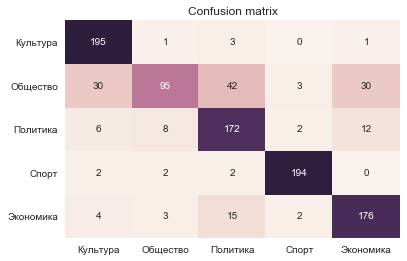

In [7]:
print("Precision: {0:6.2f}".format(precision_score(corpus_sample_test.topic, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(corpus_sample_test.topic, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(corpus_sample_test.topic, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(corpus_sample_test.topic, predictions)))
print(classification_report(corpus_sample_test.topic, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(corpus_sample_test.topic, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()